# Zadanie

Tym razem zadanie będzie polegało na stworzeniu modelu generatywnego który generował będzie nowe obrazki przedstawiające znaki drogowe. Do wyboru mają Państwo dowolny model generatywny (VAE, GAN inne opcje o których nie wspominaliśmy jak GLOW czy VAEGAN). Zbiór danych udestępniony jest przez office 365 (trafic_32.zip) i ma taką samą strukturę jak poprzednio (zgodną z domyślnymi ustawieniami ImageFolderu). Znaki podzielone są na klasy, które jak najbardziej mogą Państwo wykorzystywać do generowania próbek. Tym razem zamiast predykcji proszę o zwrócenie mi kodu z implementacją eksperymentów i przykładowe 1000 wygenerowanych za pomocą Państwa metody próbek.
Bardzo proszę żeby jak zwykle zwracali mi Państwo archiwum zip, jak zwykle proszę też o zastosowanie się do instrukcji:
- Archiwum powinno być nazwane jak ostatnio poniedzialek/piatek_nazwisko1_nazwisko2.zip (lub nazwa drużyny)
- W archiwum proszę bez zbędnych podfolderów umieścić pliki ze swoim kodem i wygenerowane obrazki nazwane odpowiednio poniedzialek_nazwisko1_nazwisko2.pt (lub nazwa drużyny)
- Wygenerowane obrazki, proszę zapisywać po prostu w formie torchowego tensora (na cpu, po detach, czyli np. wykonując komendę torch.save(generated_imgs.cpu().detach(),"poniedzialek_nazwisko1_nazwisko2.pt") ) - będzie mi łatwiej wcztać je do ewaluacji. Tensor zgodnie z konwencją powinien mieć wymiary [1000,3,32,32]

Ewaluacja:
- Wygenerowane obrazki porównywał będę do zbioru testowego za pomocą metryki Frechet Inception Distance o której wspominałem na ćwiczeniach. Jeżeli chcieliby Państwo z niej skorzystać do ewaluacji swoich modeli, to odsyłam do repozytorium z wygodną implementacją: https://github.com/mseitzer/pytorch-fid
- W zbiorze testowym obrazki mają ten sam rozkład klas co w treningowym
- Proszę pamiętać o denormalizacji próbek :)

1000 obrazków w torchowym tensorze zajmuje około 15MB, myślę że teamsy powinny sobie z tym poradzić, w razie problemów proszę o kontakt.

# Importing libraries and modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import itertools
import random

from collections import Counter
from tqdm import tqdm
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
from torch.autograd import Variable

from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

/Users/Kuba/miniforge3/envs/SSNE/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Helper functions

In [2]:
# ------- Training ------- #
def get_device():
    """Returns the available device for computation.
    Returns:
        torch.device: available device for computation
    """
    compute_device = None
    if torch.cuda.is_available():
        compute_device = torch.device('cuda')
    elif torch.backends.mps.is_available():
        compute_device = torch.device('mps')
    else:
        compute_device = torch.device('cpu')
    
    print(f'device is {compute_device}')
    return compute_device


def kullback_leibler_divergence(log_variance, mean):
    """This term acts as a regularizer in the latent space, making the distributions returned 
    by the encoder close to a standard normal distribution.
    """
    return -0.5 * torch.sum(1 + log_variance - mean.pow(2) - log_variance.exp())


def vae_loss_function(x_hat, x, mean, log_variance):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    return reproduction_loss + kullback_leibler_divergence(log_variance, mean)



# ------- Visualization ------- #
def visualize_reconstructed_images(original_images, reconstructed_images):
    imgs = torch.stack([original_images, reconstructed_images], dim=1).flatten(0, 1)
    grid = make_grid(imgs, nrow=4, normalize=False, range=(-1, 1))
    grid = grid.permute(1, 2, 0)
    if len(original_images) == 4:
        plt.figure(figsize=(10, 10))
    else:
        plt.figure(figsize=(10, 10))
    plt.title(f"Reconstructions")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()


def visualize_generated_images(generated_images):
    if generated_images is None:
        return

    grid = make_grid(generated_images, nrow=4, normalize=False, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    # if len(generated_images) == 4:
    #     plt.figure(figsize=(10,10))
    # else:
    plt.figure(figsize=(15,10))
    plt.title(f"Generations")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()


def plot_class_distribution(class_labels, class_counts, class_names, label, num_classes):
    plt.figure(figsize=(15, 5))
    plt.bar(class_labels, class_counts)

    plt.title(label)
    plt.ylabel('Count')
    plt.xlabel('Class')
    plt.xticks(range(num_classes), class_names, rotation=90)

    plt.tight_layout()
    plt.show()
    

def visualize_latent_space():
    pass


# ------- Other ------- #
def get_stacked_images(dataset, num):
    return torch.stack([dataset[i][0] for i in range(10,10+num)], dim=0)

In [3]:
class EarlyStopping():
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True

# Params and constants

In [4]:
random_seed = 100
VAL_SET_FRACTION = 0.1
NUM_IMAGES_TO_GENERATE = 40
BATCH_SIZE = 128

# device = get_device()
device = torch.device('cpu')

train_data_path = 'trafic_32/'

In [5]:
torch.manual_seed(random_seed)
np.random.seed(random_seed)

# Loading data

In [6]:
img_dataset = ImageFolder(train_data_path, transform=ToTensor())

In [7]:
img_dataset

Dataset ImageFolder
    Number of datapoints: 39209
    Root location: trafic_32/
    StandardTransform
Transform: ToTensor()

In [8]:
class_names, class_idx = img_dataset.find_classes(train_data_path)

In [9]:
num_classes = len(class_names)
num_classes

43

# Split data to train and validation sets

In [10]:
VAL_SET_SIZE = int(len(img_dataset) * VAL_SET_FRACTION)

### Datasets

In [11]:
train_dataset, val_dataset = torch.utils.data.random_split(img_dataset, [len(img_dataset) - VAL_SET_SIZE, VAL_SET_SIZE])

In [12]:
print(f'Train set size: {len(train_dataset)}')
print(f'Val set size: {len(val_dataset)}')

assert sum([len(train_dataset), len(val_dataset)]) == len(img_dataset)

Train set size: 35289
Val set size: 3920


In [13]:

input_shape = train_dataset[0][0].shape
input_shape

torch.Size([3, 32, 32])

### DataLoaders

In [14]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE*2)

# EDA

In [15]:
class_counts_dataset_full = Counter(img_dataset.targets)

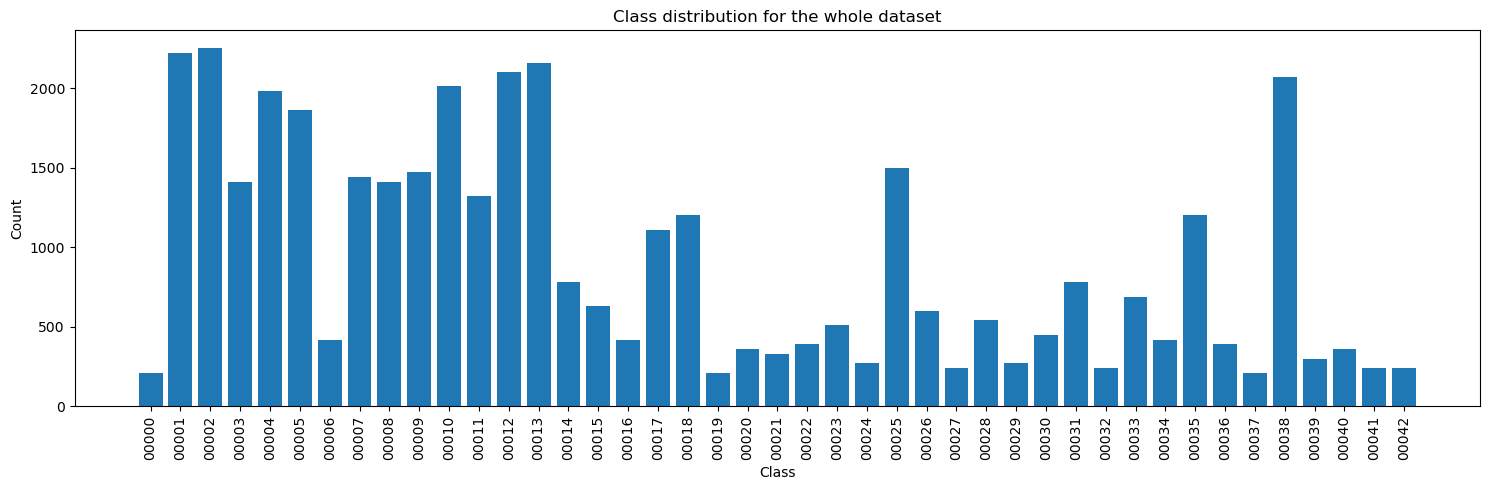

In [16]:
plot_class_distribution(class_counts_dataset_full.keys(), class_counts_dataset_full.values(), class_names, label='Class distribution for the whole dataset', num_classes=num_classes)

Some imbalances in the class labels

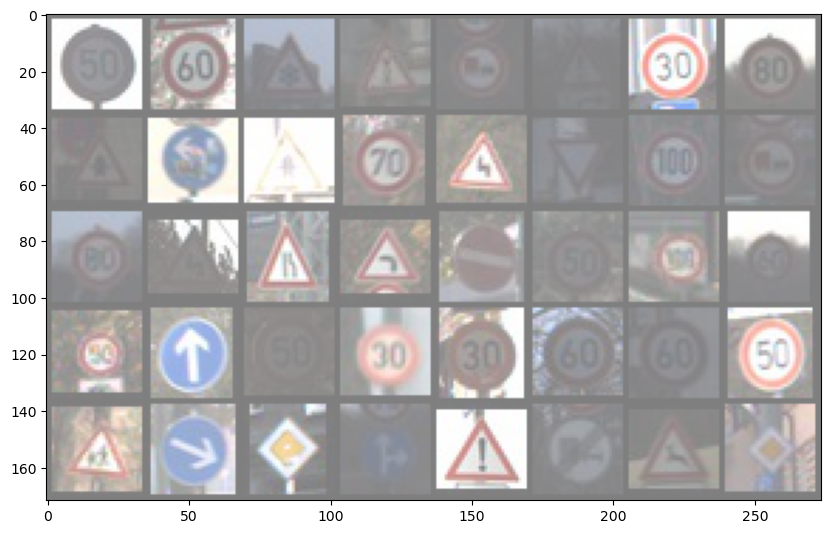

In [17]:
plt.figure(figsize=(10, 10))

sample_images, sample_labels = iter(train_dataloader).next()

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(make_grid(sample_images[:min(len(sample_images), 40)]))

In [18]:
input_shape = train_dataset[0][0].shape
input_shape

torch.Size([3, 32, 32])

# Model

- [VAE models](https://github.com/AntixK/PyTorch-VAE)
- [GAN models GitHub](https://github.com/eriklindernoren/PyTorch-GAN)
- [GAN models library](https://torchgan.readthedocs.io/en/latest/modules/models.html)
- [VAEGANs](https://github.com/unit8co/vegans)

In [19]:
class ModelTrainingEnhancer(nn.Module):
    def __init__(self, device, tensorboard_dir='runs/model', callbacks=None) -> None:
        super().__init__()
#         self.tensorboard_writer = SummaryWriter(tensorboard_dir)
        self.device = device
        self.callbacks = callbacks
        self.train_report = {
            'train_loss_history': [],
            'val_loss_history': []
        }

    def forward(self, X):
        return X
    
    def predict(self, X):
        self.eval()
        y_pred = self.forward(X)
        return torch.tensor([torch.argmax(pred) for pred in y_pred])
    
    def fit(self, train_dataloader, loss_func, optimizer, lr_scheduler=None, epochs=10, val_dataloader=None):
        self.train()
        for epoch in range(epochs):
            print('================================')
            print(f'Epoch {epoch}')
            train_epoch_loss = self._train_one_epoch(train_dataloader, loss_func, optimizer)
            avg_epoch_loss = train_epoch_loss / len(train_dataloader)
            self._log_training_loss(avg_epoch_loss, epoch)
            
            if val_dataloader is not None:
                val_loss = self.perform_validation(loss_func, val_dataloader)
                avg_val_loss = val_loss / len(val_dataloader)
                self._log_validation_loss(avg_val_loss)
                
            if epoch % 10 == 0:
                visualize_generated_images(self.generate_images(20))
            
            if self.callbacks is not None:
                if self.callbacks.get['early_stopping'] is not None:
                    self.callbacks['early_stopping'](avg_epoch_loss, avg_val_loss)
                    if self.callbacks['early_stopping'].early_stop:
                        print('Stopping early')
                        break
            if lr_scheduler is not None:
                lr_scheduler.step()
    
    def _train_one_epoch(self, train_dataloader, loss_func, optimizer):
        epoch_loss = 0.0
        for batch_samples, batch_labels in tqdm(train_dataloader):
            X = batch_samples.to(self.device)
            y = batch_labels.to(self.device)
            
            y_pred = self.forward(X)
            loss = loss_func(y_pred, y)
            self._optimize_params(loss, optimizer)
            epoch_loss += loss.item()
        return epoch_loss
            
    def _optimize_params(self, loss, optimizer):
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    def perform_validation(self, loss_func, val_dataloader):
        val_loss = 0.0
        with torch.no_grad():
            for batch_samples, batch_labels in val_dataloader:
                X = batch_samples.to(self.device)
                y = batch_labels.to(self.device)
                
                y_pred = self.forward(X)
                loss = loss_func(y_pred, y)
                val_loss += loss.item()
        return val_loss
    
    def _log_training_loss(self, epoch_loss, epoch):
        self.train_report['train_loss_history'].append(epoch_loss)
        print(f'Train Loss: {epoch_loss}')
        # self.tensorboard_writer.add_scalar('Loss_train', epoch_loss)
    
    def _log_validation_loss(self, epoch_loss):
        self.train_report['val_loss_history'].append(epoch_loss)
        print(f'Val Loss: {epoch_loss}')
        # self.tensorboard_writer.add_scalar('Loss_val', epoch_loss)
    
    def generate_images(num_images):
        return None

# Models

## - VAE

In [52]:
# Inspired by: https://medium.com/dataseries/variational-autoencoder-with-pytorch-2d359cbf027b

class VAE(ModelTrainingEnhancer):    
    def __init__(self, input_dim, latent_dim, output_dim, device, tensorboard_dir, callbacks=None) -> None:
        super().__init__(device, tensorboard_dir, callbacks)
        self.encoder = self.Encoder(input_dim, latent_dim)
        self.decoder = self.Decoder(latent_dim, output_dim)
        self.latent_dim = latent_dim
    
    def forward(self, X):
        mean, log_variance = self.encoder(X)
        # Reparametrization
        z = self.reparametrization(mean, torch.exp(0.5 * log_variance)) # takes exponential function (log var -> var)
        X_hat = self.decoder(z)
        return X_hat, mean, log_variance
    
    def reparametrization(self, mean, log_variance):
        epsilon = torch.randn_like(mean)
        z = mean + log_variance * epsilon
        return z
    
    def _train_one_epoch(self, train_dataloader, loss_func, optimizer):
        epoch_loss = 0.0
        for batch_samples, _ in tqdm(train_dataloader):
            X = batch_samples.to(self.device)
            X_out, mean, log_variance = self.forward(X)
            loss = loss_func(X_out, X, mean, log_variance)
            self._optimize_params(loss, optimizer)
            epoch_loss += loss.item()
            self.tensorboard_writer.add_scalar('Loss_train', loss)
        return epoch_loss
    
    def perform_validation(self, loss_func, val_dataloader):
        val_loss = 0.0
        with torch.no_grad():
            for batch_samples, _ in val_dataloader:
                X = batch_samples.to(self.device)
                X_out, mean, log_variance = self.forward(X)
                loss = loss_func(X_out, X, mean, log_variance)
                val_loss += loss.item()
        return val_loss
    
    def predict(self, n_images):
        return self.generate_images(n_images)
    
    def generate_images(self, num_images):
        self.eval()
        with torch.no_grad():
            generated_imgs = self.decoder(torch.randn([num_images, self.latent_dim]).to(device))
        generated_imgs = generated_imgs.cpu()
        return generated_imgs
    
    def reconstruct_images(self, X):
        self.eval()
        with torch.no_grad():
            reconst_imgs, _, _ = self.forward(X.to(device))
        return reconst_imgs.cpu()
    
    # ----- Encoder ----- #
    class Encoder(nn.Module):
        def __init__(self, input_shape, latent_dim) -> None:
            super().__init__()
            self.conv_relu_stack = nn.Sequential(
                nn.Conv2d(input_shape, 16, 3, stride=2, padding=1), # 16 x 16 x 8
                nn.BatchNorm2d(16),
                nn.LeakyReLU(True),
                nn.Conv2d(16, 32, 3, stride=2, padding=1), # 8 x 8 x 16
                nn.BatchNorm2d(32),
                nn.LeakyReLU(True),
                nn.Conv2d(32, 64, 3, stride=2, padding=1), # 4 x 4 x 32
                nn.LeakyReLU(True)
            )
            self.flatten_layer = nn.Flatten()
            
            self.linear_relu_stack = nn.Sequential(
                nn.Linear(4 * 4 * 64, 512),
                nn.LeakyReLU(True),
                nn.Linear(512, 512),
                nn.LeakyReLU(True),
                nn.Linear(512, 512),
                nn.LeakyReLU(True)
            )
            
            self.fc_mean = nn.Linear(512, latent_dim)
            self.fc_log_variance = nn.Linear(512, latent_dim)
            

        def forward(self, X):
            X = self.conv_relu_stack(X)
            X = self.flatten_layer(X)
            X = self.linear_relu_stack(X)
            
            X_mean = self.fc_mean(X)
            X_log_variance = self.fc_log_variance(X)
            return X_mean, X_log_variance
    
    
    # ----- Decoder ----- #
    class Decoder(nn.Module):
        def __init__(self, latent_dim, output_dim) -> None:
            super().__init__()
            self.linear_relu_stack = nn.Sequential(
                nn.Linear(latent_dim, 512),
                nn.LeakyReLU(True),
                nn.Linear(512, 512),
                nn.LeakyReLU(True),
                nn.Linear(512, 512),
                nn.LeakyReLU(True),
                nn.Linear(512, 4 * 4 * 64),
                nn.ReLU(True)
            )
            
            self.unflatten = nn.Unflatten(dim=1, unflattened_size=(64, 4, 4)) # reshape
            
            self.transposed_conv_relu_stack = nn.Sequential(
                nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),           
                nn.BatchNorm2d(32),
                nn.ReLU(True),
                nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
                nn.BatchNorm2d(16),
                nn.ReLU(True),
                # nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
                # nn.BatchNorm2d(8),
                # nn.ReLU(True),
                nn.ConvTranspose2d(16, output_dim, 3, stride=2, padding=1, output_padding=1),
                # nn.ReLU(True)
            )
        
        
        def forward(self, X):
            X = self.linear_relu_stack(X)
            X = self.unflatten(X)
            X = self.transposed_conv_relu_stack(X)
            return torch.sigmoid(X)

# Training

## - VAE

In [64]:
model = VAE(input_dim=input_shape[0], # 3
            latent_dim=64,
            output_dim=input_shape[0], # 3
            device=device,
            tensorboard_dir='runs/vae_model'
            ).to(device)

# model.load_state_dict(torch.load('models/model_vae_sigmoid_4.pt'))

In [59]:
loss_func = vae_loss_function

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [63]:
model.fit(train_dataloader, loss_func, optimizer, lr_scheduler, epochs=50, val_dataloader=val_dataloader)

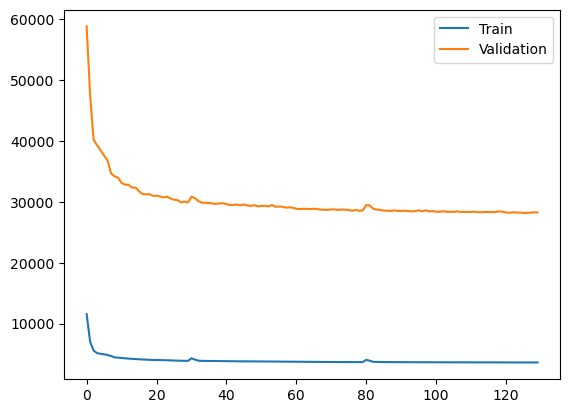

In [46]:
plt.plot(model.train_report['train_loss_history'], label='Train')
plt.plot(model.train_report['val_loss_history'], label='Validation')
plt.legend()
plt.savefig('loss_fig.png')
plt.show()


In [116]:
class VAE(ModelTrainingEnhancer):    
    def __init__(self, input_dim, latent_dim, output_dim, device, tensorboard_dir, callbacks=None) -> None:
        super().__init__(device, tensorboard_dir, callbacks)
        self.encoder = self.Encoder(input_dim, latent_dim)
        self.decoder = self.Decoder(latent_dim, output_dim)
        self.latent_dim = latent_dim
    
    def forward(self, X):
        mean, log_variance = self.encoder(X)
        # Reparametrization
        z = self.reparametrization(mean, torch.exp(0.5 * log_variance)) # takes exponential function (log var -> var)
        X_hat = self.decoder(z)
        return X_hat, mean, log_variance
    
    def reparametrization(self, mean, log_variance):
        epsilon = torch.randn_like(mean)
        z = mean + log_variance * epsilon
        return z
    
    def _train_one_epoch(self, train_dataloader, loss_func, optimizer):
        epoch_loss = 0.0
        for batch_samples, _ in tqdm(train_dataloader):
            X = batch_samples.to(self.device)
            X_out, mean, log_variance = self.forward(X)
            loss = loss_func(X_out, X, mean, log_variance)
            self._optimize_params(loss, optimizer)
            epoch_loss += loss.item()
            self.tensorboard_writer.add_scalar('Loss_train', loss)
        return epoch_loss
    
    def perform_validation(self, loss_func, val_dataloader):
        val_loss = 0.0
        with torch.no_grad():
            for batch_samples, _ in val_dataloader:
                X = batch_samples.to(self.device)
                X_out, mean, log_variance = self.forward(X)
                loss = loss_func(X_out, X, mean, log_variance)
                val_loss += loss.item()
        return val_loss
    
    def predict(self, n_images):
        return self.generate_images(n_images)
    
    def generate_images(self, num_images):
        self.eval()
        with torch.no_grad():
            generated_imgs = self.decoder(torch.randn([num_images, self.latent_dim]).to(device))
        generated_imgs = generated_imgs.cpu()
        return generated_imgs
    
    def reconstruct_images(self, X):
        self.eval()
        with torch.no_grad():
            reconst_imgs, _, _ = self.forward(X.to(device))
        return reconst_imgs.cpu()
    
    # ----- Encoder ----- #
    class Encoder(nn.Module):
        def __init__(self, input_shape, latent_dim) -> None:
            super().__init__()
            self.conv_relu_stack = nn.Sequential(
                nn.Conv2d(input_shape, 16, 3, stride=2, padding=1), # 16 x 16 x 8
                nn.BatchNorm2d(16),
                nn.LeakyReLU(True),
                nn.Conv2d(16, 32, 3, stride=2, padding=1), # 8 x 8 x 16
                nn.BatchNorm2d(32),
                nn.LeakyReLU(True),
                nn.Conv2d(32, 64, 3, stride=2, padding=1), # 4 x 4 x 32
                nn.LeakyReLU(True)
            )
            self.flatten_layer = nn.Flatten()
            
            self.linear_relu_stack = nn.Sequential(
                nn.Linear(4 * 4 * 64, 512),
                nn.LeakyReLU(True),
                nn.Linear(512, 512),
                nn.LeakyReLU(True),
                nn.Linear(512, 512),
                nn.LeakyReLU(True)
            )
            
            self.fc_mean = nn.Linear(512, latent_dim)
            self.fc_log_variance = nn.Linear(512, latent_dim)
            

        def forward(self, X):
            X = self.conv_relu_stack(X)
            X = self.flatten_layer(X)
            X = self.linear_relu_stack(X)
            
            X_mean = self.fc_mean(X)
            X_log_variance = self.fc_log_variance(X)
            return X_mean, X_log_variance
    
    
    # ----- Decoder ----- #
    class Decoder(nn.Module):
        def __init__(self, latent_dim, output_dim) -> None:
            super().__init__()
            self.linear_relu_stack = nn.Sequential(
                nn.Linear(latent_dim, 512),
                nn.LeakyReLU(True),
                nn.Linear(512, 512),
                nn.LeakyReLU(True),
                nn.Linear(512, 512),
                nn.LeakyReLU(True),
                nn.Linear(512, 4 * 4 * 64),
                nn.ReLU(True)
            )
            
            self.unflatten = nn.Unflatten(dim=1, unflattened_size=(64, 4, 4)) # reshape
            
            self.transposed_conv_relu_stack = nn.Sequential(
                nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),           
                nn.BatchNorm2d(32),
                nn.ReLU(True),
                nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
                nn.BatchNorm2d(16),
                nn.ReLU(True),
                # nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
                # nn.BatchNorm2d(8),
                # nn.ReLU(True),
                nn.ConvTranspose2d(16, output_dim, 3, stride=2, padding=1, output_padding=1),
                # nn.ReLU(True)
            )
        
        
        def forward(self, X):
            X = self.linear_relu_stack(X)
            X = self.unflatten(X)
            X = self.transposed_conv_relu_stack(X)
            return torch.sigmoid(X)

## Reconstructing images

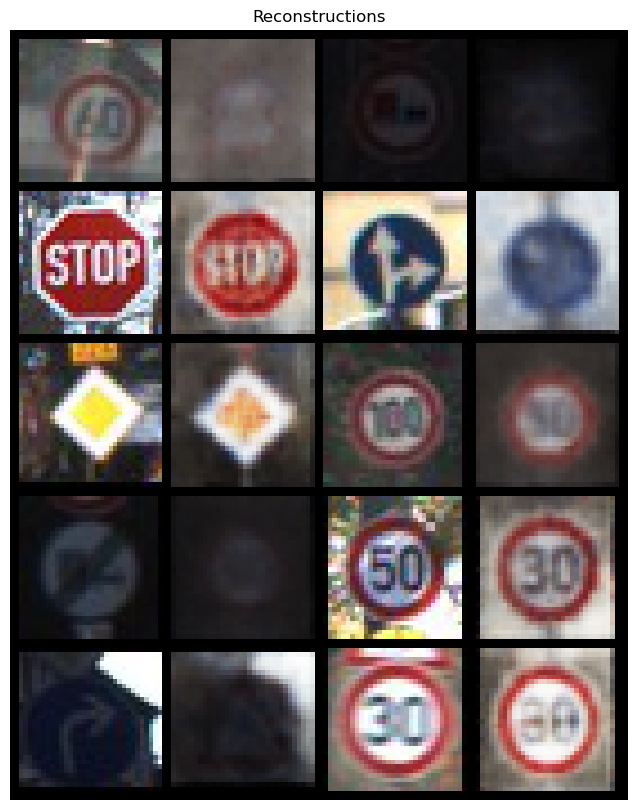

In [67]:
input_imgs = get_stacked_images(train_dataset, 10)
reconstructed_imgs = model.reconstruct_images(input_imgs)

visualize_reconstructed_images(input_imgs, reconstructed_imgs)

# Generating new data

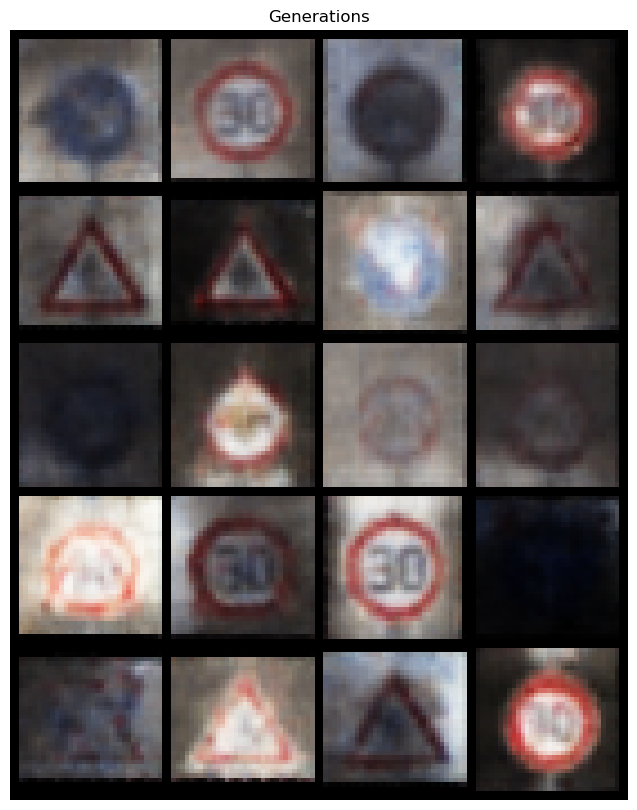

In [69]:
generated_images = model.generate_images(20)

visualize_generated_images(generated_images)

## - VanillaVAE

In [129]:
class VanillaVAE(ModelTrainingEnhancer):    
    def __init__(self, input_dim, latent_dim, output_dim, device, tensorboard_dir, callbacks=None) -> None:
        super().__init__(device, tensorboard_dir, callbacks)
        self.latent_dim = latent_dim
        self.encoder = self.Encoder(input_dim=input_dim, latent_dim=latent_dim)
        self.decoder = self.Decoder(latent_dim=latent_dim, output_dim=output_dim)
    
    def reparameterization(self, mean, var):
        eps = torch.randn_like(mean)
        z = mean + eps*var
        return z
        
                
    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat = self.decoder(z)
        return x_hat, mean, log_var
    
    def _train_one_epoch(self, train_dataloader, loss_func, optimizer):
        epoch_loss = 0.0
        for batch_samples, _ in tqdm(train_dataloader):
            X = batch_samples.to(self.device)
            X_out, mean, log_variance = self.forward(X)
            loss = loss_func(X_out, X, mean, log_variance)
            self._optimize_params(loss, optimizer)
            epoch_loss += loss.item()
        return epoch_loss
    
    def perform_validation(self, loss_func, val_dataloader):
        val_loss = 0.0
        with torch.no_grad():
            for batch_samples, _ in val_dataloader:
                X = batch_samples.to(self.device)
                X_out, mean, log_variance = self.forward(X)
                loss = loss_func(X_out, X, mean, log_variance)
                val_loss += loss.item()
        return val_loss
    
    def predict(self, n_images):
        return self.generate_images(n_images)
    
    def generate_images(self, num_images):
        self.eval()
        with torch.no_grad():
            generated_imgs = self.decoder(torch.randn([num_images, self.latent_dim]).to(device))
        generated_imgs = generated_imgs.cpu()
        return generated_imgs
    
    def reconstruct_images(self, X):
        self.eval()
        with torch.no_grad():
            reconst_imgs, _, _ = self.forward(X.to(device))
        return reconst_imgs.cpu()
    
    class Encoder(nn.Module):
        def __init__(self, input_dim, latent_dim):
            super().__init__()

            self.fc_1 = nn.Linear(input_dim, 1024)
            self.fc_2 = nn.Linear(1024, 512)
            self.fc_3 = nn.Linear(512, 256)
            self.fc_mean  = nn.Linear(256, latent_dim)
            self.fc_var   = nn.Linear (256, latent_dim)
            
            self.LeakyReLU = nn.LeakyReLU(0.2)
            
            self.training = True
            
        def forward(self, x):
            x = torch.flatten(x, 1)
            x       = self.LeakyReLU(self.fc_1(x))
            x       = self.LeakyReLU(self.fc_2(x))
            x       = self.LeakyReLU(self.fc_3(x))
            mean     = self.fc_mean(x)
            log_var  = self.fc_var(x)
            return mean, log_var

    class Decoder(nn.Module):
        def __init__(self, latent_dim, output_dim):
            super().__init__()
            self.fc_1 = nn.Linear(latent_dim, 256)
            self.fc_2 = nn.Linear(256, 512)
            self.fc_3 = nn.Linear(512, 1024)
            self.fc_out = nn.Linear(1024, output_dim)
            self.LeakyReLU = nn.LeakyReLU(0.2)
            
        def forward(self, x):
            x     = self.LeakyReLU(self.fc_1(x))
            x     = self.LeakyReLU(self.fc_2(x))
            x     = self.LeakyReLU(self.fc_3(x))
            
            x_hat = torch.sigmoid(self.fc_out(x))
            x_hat = x_hat.view([-1, 3, 32, 32])
            return x_hat

In [25]:
vanilla_vae_model = VanillaVAE(input_dim=32*32*3, latent_dim=32, output_dim=32*32*3, device=device, tensorboard_dir='runs/models').to(device)

In [26]:
loss_func = vae_loss_function

optimizer = torch.optim.Adam(vanilla_vae_model.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [55]:
vanilla_vae_model.fit(train_dataloader, loss_func, optimizer, lr_scheduler, epochs=301, val_dataloader=val_dataloader)

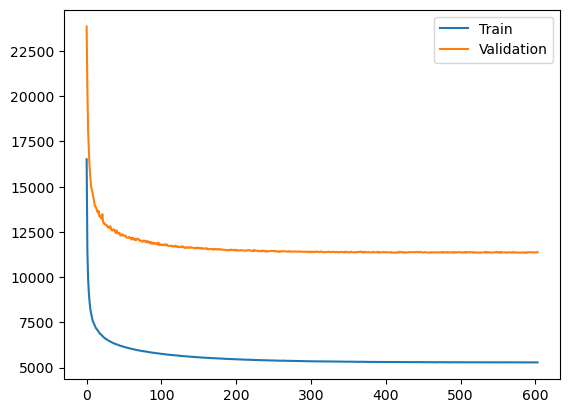

In [50]:
plt.plot(vanilla_vae_model.train_report['train_loss_history'], label='Train')
plt.plot(vanilla_vae_model.train_report['val_loss_history'], label='Validation')
plt.legend()
plt.savefig('loss_fig.png')
plt.show()

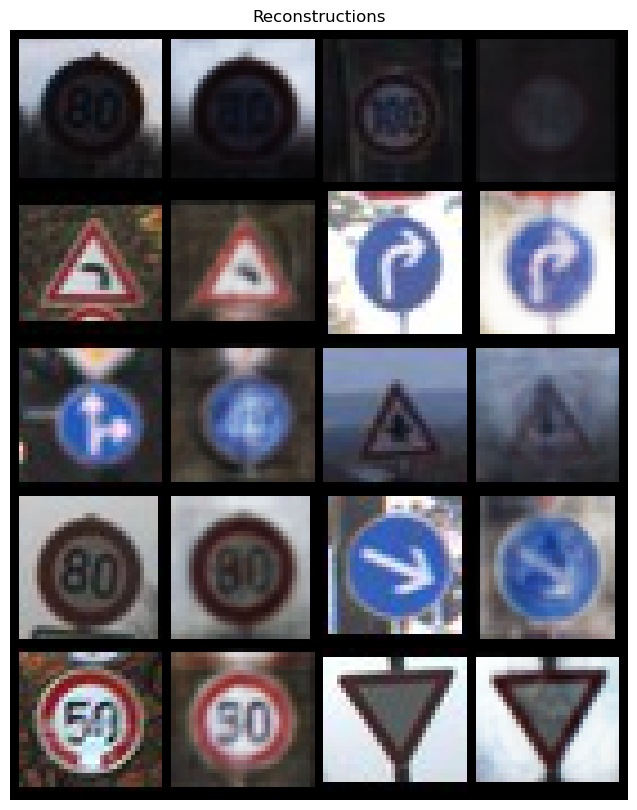

In [51]:
input_imgs = get_stacked_images(val_dataset, 10)
reconstructed_imgs = vanilla_vae_model.reconstruct_images(input_imgs)

visualize_reconstructed_images(input_imgs, reconstructed_imgs)

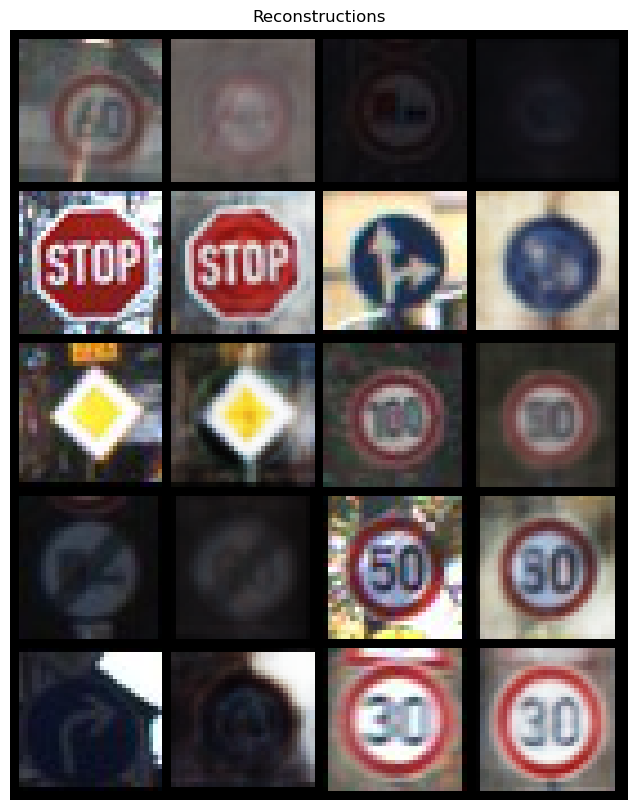

In [52]:
input_imgs = get_stacked_images(train_dataset, 10)
reconstructed_imgs = vanilla_vae_model.reconstruct_images(input_imgs)

visualize_reconstructed_images(input_imgs, reconstructed_imgs)

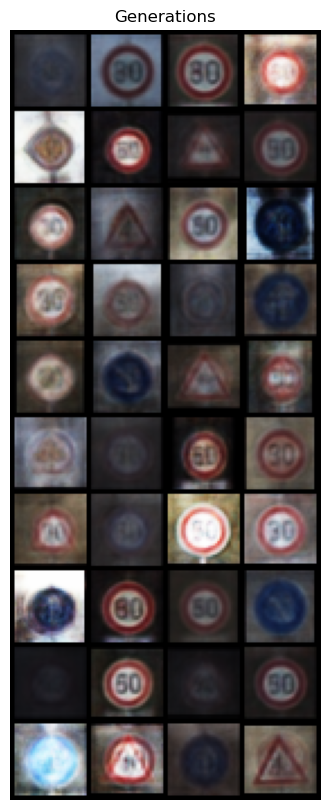

In [54]:
generated_images = vanilla_vae_model.generate_images(40)

visualize_generated_images(generated_images)

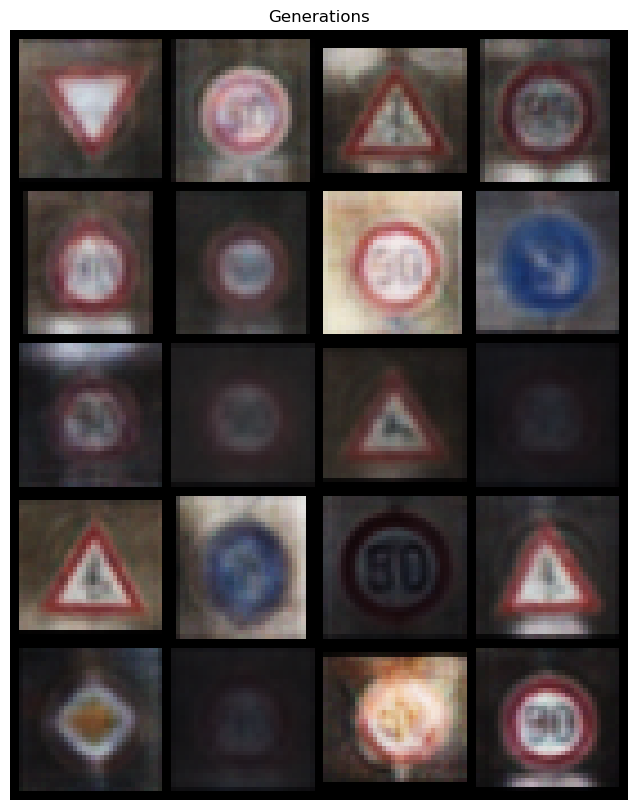

In [ ]:
generated_images = vanilla_vae_model.generate_images(20)

visualize_generated_images(generated_images)

## - ConvVAE

In [20]:
class ConvVAE(ModelTrainingEnhancer):    
    def __init__(self, input_dim, latent_dim, output_dim, device, tensorboard_dir, callbacks=None) -> None:
        super().__init__(device, tensorboard_dir, callbacks)
        self.latent_dim = latent_dim
        self.encoder = self.Encoder(input_dim=input_dim, latent_dim=latent_dim)
        self.decoder = self.Decoder(latent_dim=latent_dim, output_dim=output_dim)
    
    def reparameterization(self, mean, var):
        eps = torch.randn_like(mean)
        z = mean + eps*var
        return z
        
    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var))
        x_hat = self.decoder(z)
        return x_hat, mean, log_var
    
    def _train_one_epoch(self, train_dataloader, loss_func, optimizer):
        epoch_loss = 0.0
        for batch_samples, _ in tqdm(train_dataloader):
            X = batch_samples.to(self.device)
            X_out, mean, log_variance = self.forward(X)
            loss = loss_func(X_out, X, mean, log_variance)
            self._optimize_params(loss, optimizer)
            epoch_loss += loss.item()
        return epoch_loss
    
    def perform_validation(self, loss_func, val_dataloader):
        val_loss = 0.0
        with torch.no_grad():
            for batch_samples, _ in val_dataloader:
                X = batch_samples.to(self.device)
                X_out, mean, log_variance = self.forward(X)
                loss = loss_func(X_out, X, mean, log_variance)
                val_loss += loss.item()
        return val_loss
    
    def predict(self, n_images):
        return self.generate_images(n_images)
    
    def generate_images(self, num_images):
        self.eval()
        with torch.no_grad():
            generated_imgs = self.decoder(torch.randn([num_images, self.latent_dim]).to(device))
        generated_imgs = generated_imgs.cpu()
        return generated_imgs
    
    def reconstruct_images(self, X):
        self.eval()
        with torch.no_grad():
            reconst_imgs, _, _ = self.forward(X.to(device))
        return reconst_imgs.cpu()


    class Encoder(nn.Module):
        def __init__(self, input_dim, latent_dim):
            super().__init__()

            self.conv_relu_stack = nn.Sequential(
                nn.Conv2d(input_dim, 16, 3, stride=2, padding=1), # 16 x 16 x 8
                nn.LeakyReLU(True),
                nn.Conv2d(16, 32, 3, stride=2, padding=1), # 8 x 8 x 16
                nn.LeakyReLU(True),
                nn.Conv2d(32, 64, 3, stride=2, padding=1), # 4 x 4 x 32
                nn.LeakyReLU(True)
            )
            self.flatten_layer = nn.Flatten()

            self.linear_relu_stack = nn.Sequential(
                nn.Linear(4 * 4 * 64, 256),
                nn.LeakyReLU(True),
                nn.Linear(256, 128),
                nn.LeakyReLU(True),
            )
            self.fc_mean = nn.Linear(128, latent_dim)
            self.fc_log_variance = nn.Linear(128, latent_dim)
            self.LeakyReLU = nn.LeakyReLU(0.2)

        def forward(self, X):
            X = self.conv_relu_stack(X)
            X = self.flatten_layer(X)
            X = self.linear_relu_stack(X)
            X_mean = self.fc_mean(X)
            X_log_variance = self.fc_log_variance(X)
            return X_mean, X_log_variance


    class Decoder(nn.Module):
        def __init__(self, latent_dim, output_dim):
            super().__init__()
            self.fc_1 = nn.Linear(latent_dim, 256)
            self.fc_2 = nn.Linear(256, 512)
            self.fc_3 = nn.Linear(512, 1024)
            self.fc_out = nn.Linear(1024, output_dim)
            self.LeakyReLU = nn.LeakyReLU(0.2)
            
        def forward(self, x):
            x     = self.LeakyReLU(self.fc_1(x))
            x     = self.LeakyReLU(self.fc_2(x))
            x     = self.LeakyReLU(self.fc_3(x))
            
            x_hat = torch.sigmoid(self.fc_out(x))
            x_hat = x_hat.view([-1, 3, 32, 32])
            return x_hat

In [23]:
conv_vae_model = ConvVAE(input_dim=input_shape[0], latent_dim=128, output_dim=32*32*3, device=device, tensorboard_dir='runs/models').to(device)

conv_vae_model.load_state_dict(torch.load('models/model_conv_vae_big_1.pt'))

<All keys matched successfully>

In [108]:
loss_func = vae_loss_function

optimizer = torch.optim.Adam(conv_vae_model.parameters(), lr=0.0002)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

Epoch 0


100%|██████████| 276/276 [00:24<00:00, 11.33it/s]


Train Loss: 5698.9870658542795
Val Loss: 12010.432846069336


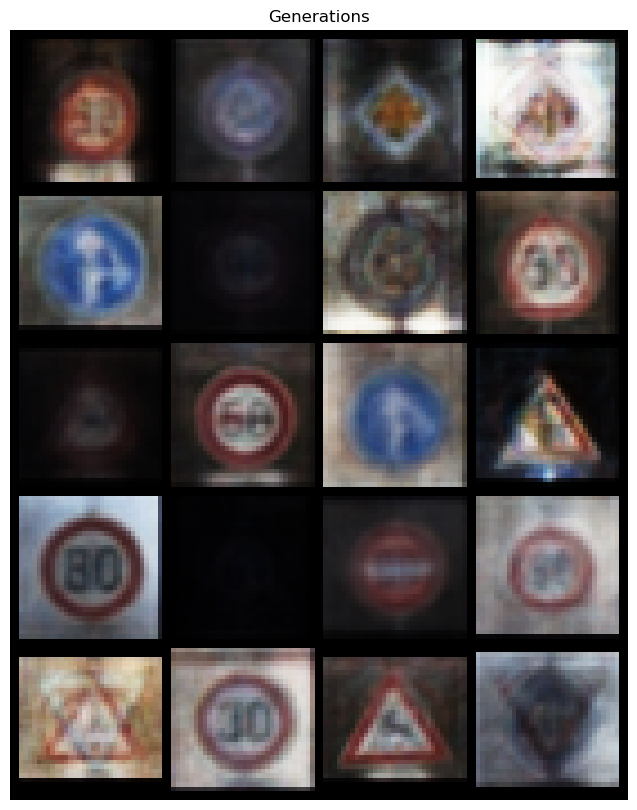

Epoch 1


100%|██████████| 276/276 [00:19<00:00, 14.02it/s]


Train Loss: 5695.755901834239
Val Loss: 12011.94613647461
Epoch 2


100%|██████████| 276/276 [00:17<00:00, 15.45it/s]


Train Loss: 5693.07945273579
Val Loss: 12022.307830810547
Epoch 3


100%|██████████| 276/276 [00:18<00:00, 14.79it/s]


Train Loss: 5686.889513983243
Val Loss: 12039.251556396484
Epoch 4


100%|██████████| 276/276 [00:20<00:00, 13.43it/s]


Train Loss: 5685.4232956153755
Val Loss: 11996.268127441406
Epoch 5


100%|██████████| 276/276 [00:21<00:00, 12.78it/s]


Train Loss: 5681.2770447661915
Val Loss: 12044.785842895508
Epoch 6


100%|██████████| 276/276 [00:21<00:00, 12.72it/s]


Train Loss: 5681.4825510218525
Val Loss: 12018.781875610352
Epoch 7


100%|██████████| 276/276 [00:21<00:00, 13.00it/s]


Train Loss: 5681.9592161316805
Val Loss: 12017.447036743164
Epoch 8


100%|██████████| 276/276 [00:19<00:00, 13.84it/s]


Train Loss: 5673.7297876330385
Val Loss: 12031.413452148438
Epoch 9


100%|██████████| 276/276 [00:19<00:00, 13.98it/s]


Train Loss: 5674.306389407835
Val Loss: 12007.203094482422
Epoch 10


100%|██████████| 276/276 [00:19<00:00, 14.35it/s]


Train Loss: 5670.041298686594
Val Loss: 12008.679428100586


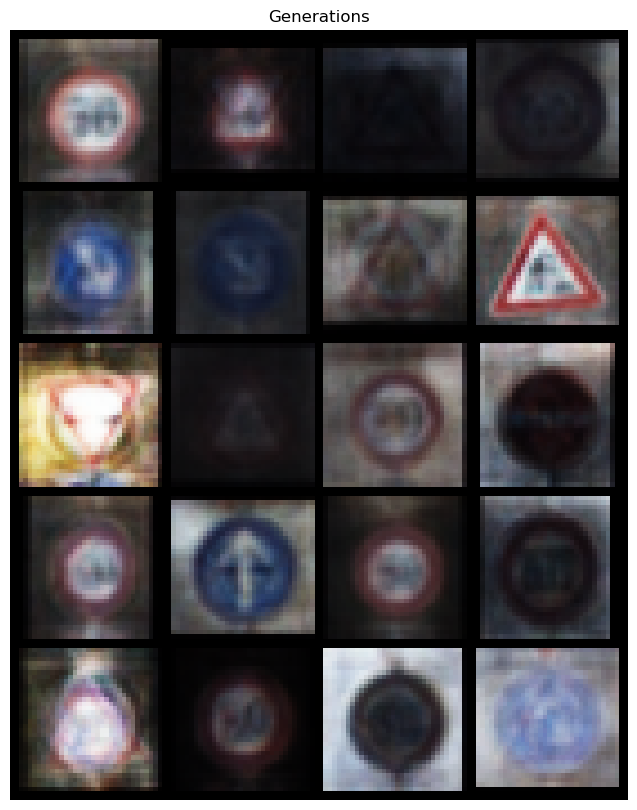

Epoch 11


100%|██████████| 276/276 [00:19<00:00, 13.90it/s]


Train Loss: 5668.188579172328
Val Loss: 12002.293731689453
Epoch 12


100%|██████████| 276/276 [00:19<00:00, 14.23it/s]


Train Loss: 5666.326759227808
Val Loss: 12028.351959228516
Epoch 13


100%|██████████| 276/276 [00:19<00:00, 14.21it/s]


Train Loss: 5662.4854028674135
Val Loss: 12002.864624023438
Epoch 14


100%|██████████| 276/276 [00:19<00:00, 14.50it/s]


Train Loss: 5656.684279289799
Val Loss: 11984.997192382812
Epoch 15


100%|██████████| 276/276 [00:18<00:00, 14.57it/s]


Train Loss: 5664.146184506623
Val Loss: 12033.621948242188
Epoch 16


100%|██████████| 276/276 [00:18<00:00, 14.67it/s]


Train Loss: 5657.5863320170965
Val Loss: 11978.041275024414
Epoch 17


100%|██████████| 276/276 [00:19<00:00, 13.98it/s]


Train Loss: 5656.054457512455
Val Loss: 11984.986022949219
Epoch 18


100%|██████████| 276/276 [00:19<00:00, 13.97it/s]


Train Loss: 5647.52344103827
Val Loss: 11991.337280273438
Epoch 19


100%|██████████| 276/276 [00:19<00:00, 13.93it/s]


Train Loss: 5651.136488762455
Val Loss: 12017.675796508789
Epoch 20


100%|██████████| 276/276 [00:19<00:00, 13.97it/s]


Train Loss: 5646.077473958333
Val Loss: 12006.047836303711


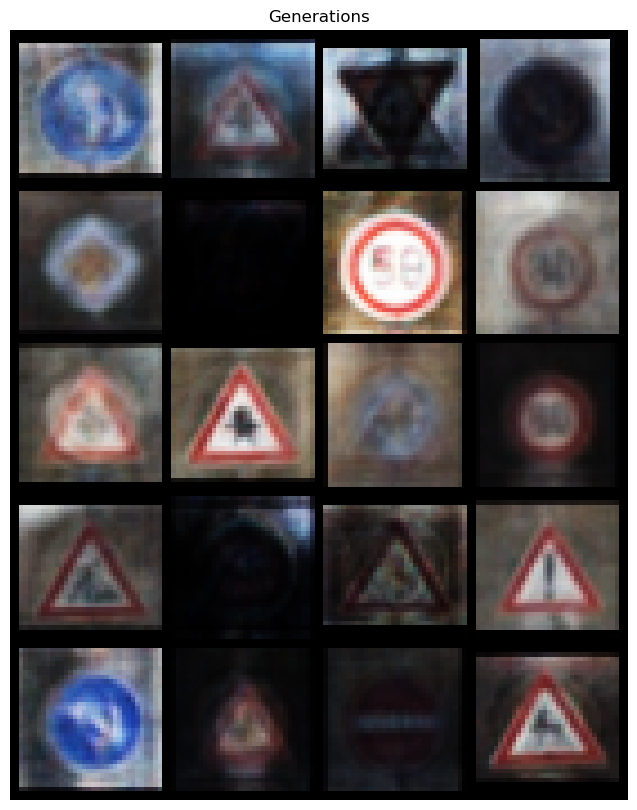

Epoch 21


100%|██████████| 276/276 [00:19<00:00, 13.84it/s]


Train Loss: 5640.985535552536
Val Loss: 11992.239028930664
Epoch 22


100%|██████████| 276/276 [00:19<00:00, 13.85it/s]


Train Loss: 5640.165223052536
Val Loss: 11993.61831665039
Epoch 23


100%|██████████| 276/276 [00:19<00:00, 13.85it/s]


Train Loss: 5641.762723618659
Val Loss: 11989.341003417969
Epoch 24


100%|██████████| 276/276 [00:20<00:00, 13.75it/s]


Train Loss: 5637.2465448794155
Val Loss: 11977.535766601562
Epoch 25


100%|██████████| 276/276 [00:21<00:00, 12.96it/s]


Train Loss: 5641.4099421846695
Val Loss: 12002.245178222656
Epoch 26


100%|██████████| 276/276 [00:21<00:00, 12.81it/s]


Train Loss: 5634.775338435518
Val Loss: 11969.890014648438
Epoch 27


100%|██████████| 276/276 [00:21<00:00, 12.68it/s]


Train Loss: 5635.008687337239
Val Loss: 11983.121307373047
Epoch 28


100%|██████████| 276/276 [00:21<00:00, 12.69it/s]


Train Loss: 5630.527365864187
Val Loss: 11992.268951416016
Epoch 29


100%|██████████| 276/276 [00:22<00:00, 12.45it/s]


Train Loss: 5634.706743765569
Val Loss: 11985.310791015625
Epoch 30


100%|██████████| 276/276 [00:22<00:00, 12.40it/s]


Train Loss: 5620.4903953662815
Val Loss: 11970.099151611328


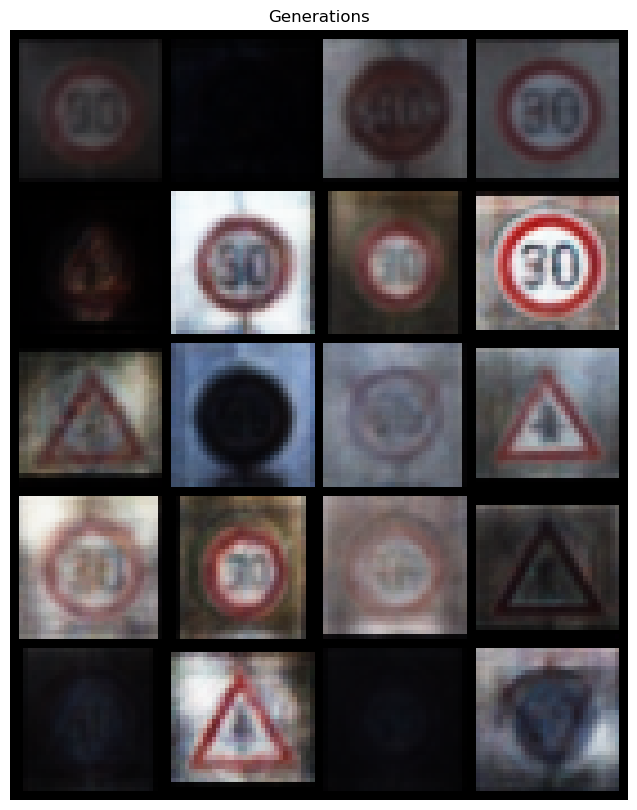

Epoch 31


100%|██████████| 276/276 [00:21<00:00, 12.56it/s]


Train Loss: 5622.000622735507
Val Loss: 11972.494247436523
Epoch 32


100%|██████████| 276/276 [00:22<00:00, 12.43it/s]


Train Loss: 5622.59474779212
Val Loss: 11989.612380981445
Epoch 33


100%|██████████| 276/276 [00:22<00:00, 12.52it/s]


Train Loss: 5618.100186112998
Val Loss: 11993.999298095703
Epoch 34


100%|██████████| 276/276 [00:21<00:00, 12.71it/s]


Train Loss: 5616.740411288496
Val Loss: 11978.671844482422
Epoch 35


100%|██████████| 276/276 [00:21<00:00, 12.74it/s]


Train Loss: 5620.19320103742
Val Loss: 11974.781127929688
Epoch 36


100%|██████████| 276/276 [00:24<00:00, 11.28it/s]


Train Loss: 5612.500452898551
Val Loss: 12000.457550048828
Epoch 37


100%|██████████| 276/276 [00:21<00:00, 12.98it/s]


Train Loss: 5610.633017719656
Val Loss: 11975.496795654297
Epoch 38


100%|██████████| 276/276 [02:37<00:00,  1.75it/s]


Train Loss: 5607.4286030202675
Val Loss: 11990.320816040039
Epoch 39


100%|██████████| 276/276 [00:20<00:00, 13.46it/s]


Train Loss: 5610.383572343467
Val Loss: 11977.629486083984
Epoch 40


100%|██████████| 276/276 [00:20<00:00, 13.39it/s]


Train Loss: 5606.1312362007475
Val Loss: 11964.445678710938


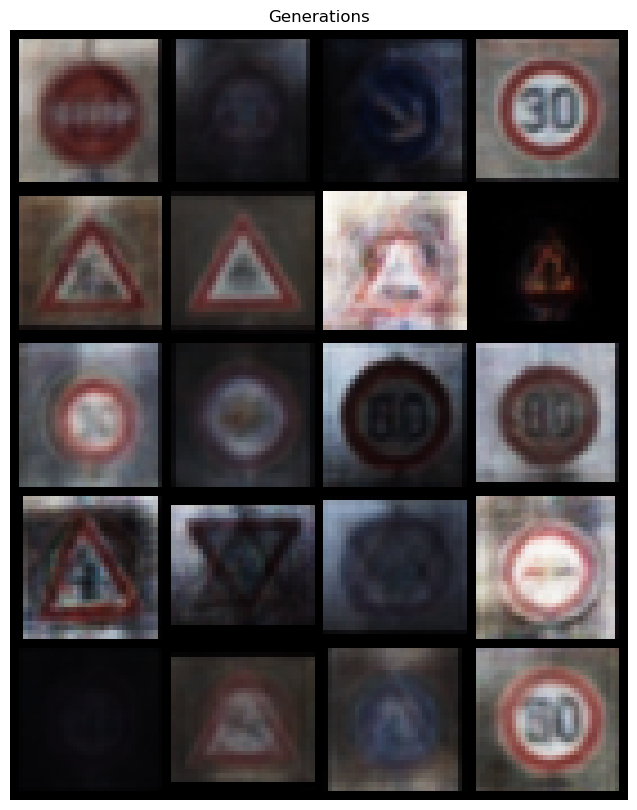

Epoch 41


100%|██████████| 276/276 [09:20<00:00,  2.03s/it] 


Train Loss: 5607.342445262964
Val Loss: 11985.688110351562
Epoch 42


100%|██████████| 276/276 [00:23<00:00, 11.83it/s]


Train Loss: 5598.902549854223
Val Loss: 11973.794021606445
Epoch 43


100%|██████████| 276/276 [00:23<00:00, 11.79it/s]


Train Loss: 5606.484913701596
Val Loss: 12006.831161499023
Epoch 44


100%|██████████| 276/276 [00:23<00:00, 11.82it/s]


Train Loss: 5605.0663761747055
Val Loss: 11959.21987915039
Epoch 45


100%|██████████| 276/276 [00:25<00:00, 11.01it/s]


Train Loss: 5594.0842055168705
Val Loss: 11946.201354980469
Epoch 46


100%|██████████| 276/276 [00:26<00:00, 10.31it/s]


Train Loss: 5597.3420781674595
Val Loss: 11979.181060791016
Epoch 47


100%|██████████| 276/276 [00:28<00:00,  9.55it/s]


Train Loss: 5590.58497862885
Val Loss: 11972.684860229492
Epoch 48


100%|██████████| 276/276 [00:22<00:00, 12.20it/s]


Train Loss: 5593.5454508463545
Val Loss: 11959.621307373047
Epoch 49


100%|██████████| 276/276 [00:21<00:00, 12.79it/s]


Train Loss: 5592.3263540959015
Val Loss: 11971.689956665039
Epoch 50


100%|██████████| 276/276 [00:20<00:00, 13.54it/s]


Train Loss: 5590.7612216230755
Val Loss: 11977.85952758789


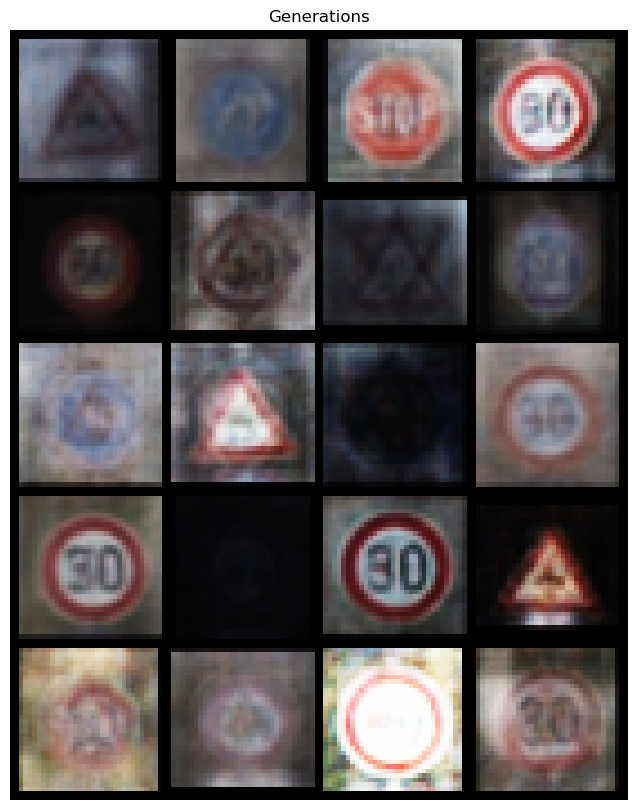

In [143]:
conv_vae_model.fit(train_dataloader, loss_func, optimizer, lr_scheduler, epochs=51, val_dataloader=val_dataloader)

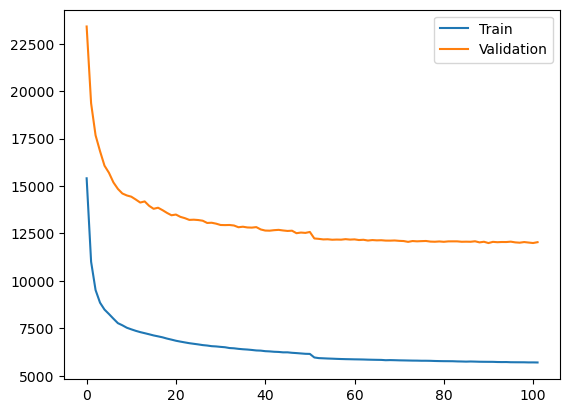

In [110]:
plt.plot(conv_vae_model.train_report['train_loss_history'], label='Train')
plt.plot(conv_vae_model.train_report['val_loss_history'], label='Validation')
plt.legend()
plt.savefig('loss_fig.png')
plt.show()

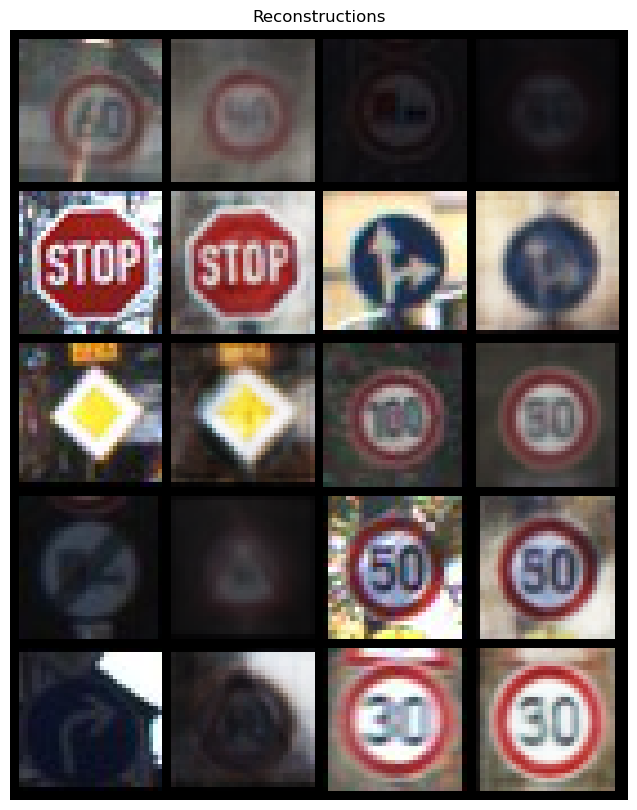

In [111]:
input_imgs = get_stacked_images(train_dataset, 10)
reconstructed_imgs = conv_vae_model.reconstruct_images(input_imgs)

visualize_reconstructed_images(input_imgs, reconstructed_imgs)

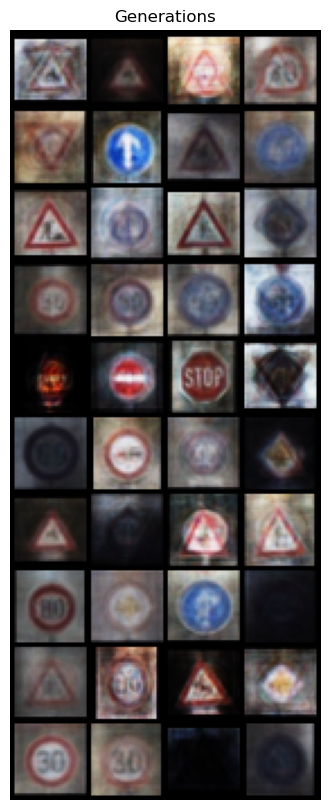

In [112]:
generated_images = conv_vae_model.generate_images(40)

visualize_generated_images(generated_images)

In [113]:
torch.save(conv_vae_model.state_dict(), 'models/model_conv_vae_big_1.pt')

## - DCGAN

In [144]:
# Inspired by: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html


def initialize_weights(cls):
        classname = cls.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(cls.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(cls.weight.data, 1.0, 0.02)
            nn.init.constant_(cls.bias.data, 0)

    
class DCGAN(nn.Module):
    def __init__(self, latent_dim, hidden_dim, device) -> None:
        super().__init__()
        self.device = device
        self.train_report = {
            'generator_loss_history': [],
            'discriminator_loss_history': []
        }
        self.generator = self.Generator(latent_dim, hidden_dim=32, output_dim=3).apply(initialize_weights)
        self.discriminator = self.Discriminator(input_dim=3, hidden_dim=32, output_dim=1).apply(initialize_weights)

    def fit(self, train_dataloader, loss_func, generator_optimizer, discriminator_optimizer, generator_lr_scheduler=None, discriminator_lr_scheduler=None, epochs=10):
        fixed_input_noise = torch.randn(min(40, BATCH_SIZE), self.generator.latent_dim, 1, 1, device=device)
        
        self.train()
        for epoch in range(epochs):
            print('================================')
            print(f'Epoch {epoch}')
            discriminator_epoch_loss, generator_epoch_loss, discriminator_acc_real, discriminator_acc_fake = self._train_one_epoch(train_dataloader, 
                                                                                                                                   loss_func,
                                                                                                                                   discriminator_optimizer, 
                                                                                                                                   generator_optimizer)

            if generator_lr_scheduler is not None:
                generator_lr_scheduler.step()
            if discriminator_lr_scheduler is not None:
                discriminator_lr_scheduler.step()

            # Logging
            self.train_report['generator_loss_history'].append(generator_epoch_loss)
            self.train_report['discriminator_loss_history'].append(discriminator_epoch_loss)
                
            # Output training stats
            if epoch % 2 == 0:
                self._log_training_loss(discriminator_epoch_loss, generator_epoch_loss)
                self._log_discriminator_acc(discriminator_acc_real, discriminator_acc_fake)
        
            if epoch % 10 == 0:
                generated_imgs = self.generate_images(fixed_input_noise)
                visualize_generated_images(generated_imgs)
    
    def _train_one_epoch(self, train_dataloader, loss_func, discriminator_optimizer, generator_optimizer):
        discriminator_epoch_loss = 0.0
        generator_epoch_loss = 0.0
        discriminator_epoch_acc_real = 0.0
        discriminator_epoch_acc_fake = 0.0
        
        for batch_samples, _ in tqdm(train_dataloader):
            # (1) Update Discriminator: maximize log(D(x)) + log(1 - D(G(z)))
            # (1.1) Train with all-real batch
            discriminator_optimizer.zero_grad()
            X_real = batch_samples.to(self.device)
            batch_size = X_real.size(0)
            label = torch.ones((batch_size,), dtype=torch.float, device=self.device)
            
            # Forward pass real batch through Discriminator
            output = self.discriminator.forward(X_real).view(-1)
            discriminator_loss_real = loss_func(output, label)
            # Calculate gradients for Discriminator in backward pass
            discriminator_loss_real.backward()  # TODO: self._optimize_params(generator_loss, generator_optimizer)  ### No step calling
            discriminator_epoch_acc_real += output.mean().item()

            # (1.2) Train with all-fake batch
            # Generate fake image batch with Generator
            input_noise = torch.randn(batch_size, self.generator.latent_dim, 1, 1, device=device)
            X_generated = self.generator.forward(input_noise)
            label = torch.zeros((batch_size,), dtype=torch.float, device=self.device)
            # Classify all-fake batch with Discriminator
            output = self.discriminator.forward(X_generated.detach()).view(-1)
            discriminator_loss_fake = loss_func(output, label)
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            discriminator_loss_fake.backward()
            discriminator_epoch_acc_fake += output.mean().item()
            # Compute error of Discriminator as sum over the fake and the real batches
            discriminator_loss = discriminator_loss_real + discriminator_loss_fake
            discriminator_epoch_loss += discriminator_loss.item()
            # Update Discriminator
            discriminator_optimizer.step()

            # (2) Update Generator network: maximize log(D(G(z)))
            self.generator.zero_grad()
            label = torch.ones((batch_size,), dtype=torch.float, device=self.device)  # fake labels are real for generator cost
            # Since we just updated Discriminator, perform another forward pass of all-fake batch through Discriminator
            output = self.discriminator.forward(X_generated).view(-1)
            generator_loss = loss_func(output, label)
            # Calculate gradients and update Generator
            generator_loss.backward()
            generator_epoch_loss += generator_loss.item()
            generator_optimizer.step() # TODO: self._optimize_params(generator_loss, generator_optimizer)
        discriminator_epoch_acc_real /= len(train_dataloader)
        discriminator_epoch_acc_fake /= len(train_dataloader)
        return discriminator_epoch_loss, generator_epoch_loss, discriminator_epoch_acc_real, discriminator_epoch_acc_fake

    def generate_images(self, fixed_input_noise):
        self.eval()
        with torch.no_grad():
            generated_imgs = self.generator(fixed_input_noise).detach().cpu()
        return generated_imgs
    
    def _train_one_epoch_discriminator(self):
        pass
    
    def _train_one_epoch_generator(self):
        pass
    
    def _log_training_loss(self, discriminator_epoch_loss, generator_epoch_loss):
        print(f"Discrimiantor loss: {discriminator_epoch_loss:.3}, Generator loss: {generator_epoch_loss:.3}")
    
    def _log_discriminator_acc(self, discriminator_acc_real, discriminator_acc_fake):
        print(f"Discrimiantor fake acc: {discriminator_acc_fake:.3}, Discriminator real acc: {discriminator_acc_real:.3}")

    
    # ----- Generator ----- #
    class Generator(nn.Module):
        def __init__(self, latent_dim, hidden_dim, output_dim) -> None:
            super().__init__()
            self.latent_dim = latent_dim
            self.transposed_conv_relu_stack = nn.Sequential(
                nn.ConvTranspose2d(latent_dim, hidden_dim * 8, 4, 1, 0, bias=False),           
                nn.BatchNorm2d(hidden_dim * 8),
                nn.LeakyReLU(True),
                nn.ConvTranspose2d(hidden_dim * 8, hidden_dim * 4, 4, 2, 1, bias=False),
                nn.BatchNorm2d(hidden_dim * 4),
                nn.LeakyReLU(True),
                nn.ConvTranspose2d(hidden_dim * 4, hidden_dim * 2, 4, 2, 1, bias=False),
                nn.BatchNorm2d(hidden_dim * 2),
                nn.LeakyReLU(True),
                nn.ConvTranspose2d(hidden_dim * 2, output_dim, 4, 2, 1, bias=False),
            )
        
        def forward(self, X):
            X = self.transposed_conv_relu_stack(X)
            return torch.sigmoid(X)
    
    
    # ----- Discriminator ----- #
    class Discriminator(nn.Module):
        def __init__(self, input_dim, hidden_dim, output_dim=1) -> None:
            super().__init__()
            self.conv_relu_stack = nn.Sequential(
                # input is (nc) x 32 x 32
                nn.Conv2d(input_dim, 16, 4, 2, 1, bias=False),
                # nn.BatchNorm2d(16),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. (ndf) x 16 x 16
                nn.Conv2d(16, 32, 4, 2, 1, bias=False),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. (ndf*2) x 8 x 8
                nn.Conv2d(32, 64, 4, 2, 1, bias=False),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. (ndf*4) x 4 x 4
                nn.Conv2d(64, 128, 4, 1, 0, bias=False),
                # nn.Sigmoid()
            )
            self.fc_1 = nn.Linear(1 * 1 * 128, 256)
            self.fc_out = nn.Linear(256, 1)
            self.LeakyReLU = nn.LeakyReLU(0.2)
        
        def forward(self, X):
            X = self.conv_relu_stack(X)
            X = self.LeakyReLU(self.fc_1(X))
            X = self.LeakyReLU(self.fc_out(X))
            return X

In [31]:
dcgan_model = DCGAN(latent_dim=64, hidden_dim=40, device=device).to(device)
# dcgan_model

In [32]:
# Optimizers
generator_optimizer = torch.optim.Adam(dcgan_model.generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
discriminator_optimizer = torch.optim.Adam(dcgan_model.discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# LR Schedulers
generator_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=generator_optimizer, gamma=0.99)
discriminator_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=discriminator_optimizer, gamma=0.99)

# Loss
loss_func = nn.MSELoss()

Epoch 0


100%|██████████| 138/138 [01:18<00:00,  1.77it/s]

Discrimiantor loss: 24.6, Generator loss: 1.11e+02
Discrimiantor fake acc: 0.171, Discriminator real acc: 0.822


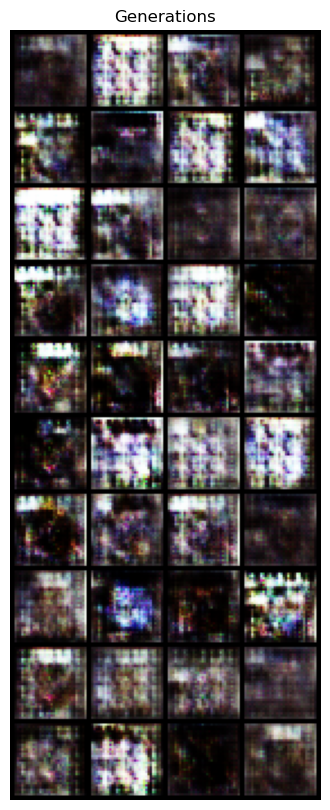

Epoch 1


100%|██████████| 138/138 [01:35<00:00,  1.44it/s]


Epoch 2


100%|██████████| 138/138 [02:13<00:00,  1.03it/s]


Discrimiantor loss: 23.6, Generator loss: 95.7
Discrimiantor fake acc: 0.19, Discriminator real acc: 0.811
Epoch 3


100%|██████████| 138/138 [02:12<00:00,  1.04it/s]


Epoch 4


100%|██████████| 138/138 [02:11<00:00,  1.05it/s]


Discrimiantor loss: 20.0, Generator loss: 1.04e+02
Discrimiantor fake acc: 0.161, Discriminator real acc: 0.84
Epoch 5


100%|██████████| 138/138 [01:15<00:00,  1.83it/s]


Epoch 6


100%|██████████| 138/138 [00:50<00:00,  2.76it/s]


Discrimiantor loss: 18.6, Generator loss: 1.09e+02
Discrimiantor fake acc: 0.135, Discriminator real acc: 0.866
Epoch 7


100%|██████████| 138/138 [00:52<00:00,  2.62it/s]


Epoch 8


100%|██████████| 138/138 [00:50<00:00,  2.76it/s]


Discrimiantor loss: 18.8, Generator loss: 1.06e+02
Discrimiantor fake acc: 0.142, Discriminator real acc: 0.858
Epoch 9


100%|██████████| 138/138 [00:50<00:00,  2.72it/s]


Epoch 10


100%|██████████| 138/138 [00:51<00:00,  2.67it/s]

Discrimiantor loss: 19.9, Generator loss: 1.05e+02
Discrimiantor fake acc: 0.148, Discriminator real acc: 0.852


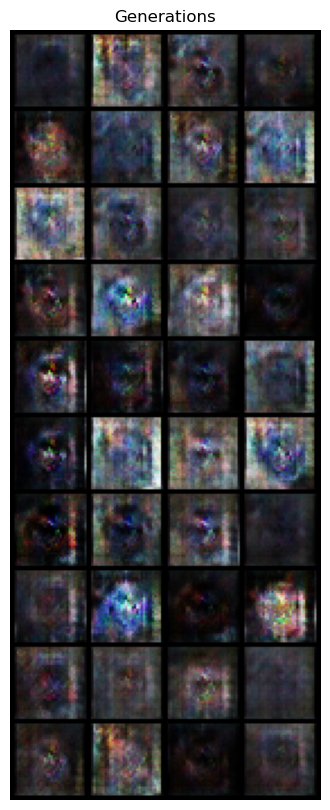

Epoch 11


100%|██████████| 138/138 [00:49<00:00,  2.78it/s]


Epoch 12


100%|██████████| 138/138 [00:49<00:00,  2.78it/s]


Discrimiantor loss: 19.3, Generator loss: 1.06e+02
Discrimiantor fake acc: 0.146, Discriminator real acc: 0.854
Epoch 13


100%|██████████| 138/138 [01:35<00:00,  1.45it/s]


Epoch 14


100%|██████████| 138/138 [01:25<00:00,  1.61it/s]


Discrimiantor loss: 19.3, Generator loss: 1.06e+02
Discrimiantor fake acc: 0.148, Discriminator real acc: 0.851
Epoch 15


100%|██████████| 138/138 [02:45<00:00,  1.20s/it]


Epoch 16


100%|██████████| 138/138 [02:09<00:00,  1.07it/s]


Discrimiantor loss: 18.0, Generator loss: 1.09e+02
Discrimiantor fake acc: 0.135, Discriminator real acc: 0.866
Epoch 17


100%|██████████| 138/138 [00:53<00:00,  2.60it/s]


Epoch 18


100%|██████████| 138/138 [00:53<00:00,  2.60it/s]


Discrimiantor loss: 16.9, Generator loss: 1.1e+02
Discrimiantor fake acc: 0.125, Discriminator real acc: 0.876
Epoch 19


100%|██████████| 138/138 [02:15<00:00,  1.02it/s]


Epoch 20


100%|██████████| 138/138 [02:32<00:00,  1.11s/it]

Discrimiantor loss: 18.1, Generator loss: 1.08e+02
Discrimiantor fake acc: 0.135, Discriminator real acc: 0.862


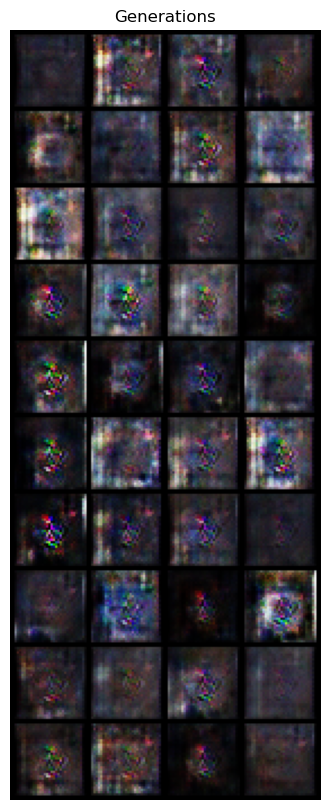

Epoch 21


100%|██████████| 138/138 [03:43<00:00,  1.62s/it]


Epoch 22


100%|██████████| 138/138 [01:56<00:00,  1.19it/s]


Discrimiantor loss: 16.8, Generator loss: 1.12e+02
Discrimiantor fake acc: 0.121, Discriminator real acc: 0.881
Epoch 23


100%|██████████| 138/138 [03:10<00:00,  1.38s/it]


Epoch 24


100%|██████████| 138/138 [05:07<00:00,  2.23s/it]


Discrimiantor loss: 16.2, Generator loss: 1.12e+02
Discrimiantor fake acc: 0.118, Discriminator real acc: 0.882
Epoch 25


100%|██████████| 138/138 [04:08<00:00,  1.80s/it]


Epoch 26


100%|██████████| 138/138 [03:19<00:00,  1.45s/it]


Discrimiantor loss: 16.1, Generator loss: 1.11e+02
Discrimiantor fake acc: 0.121, Discriminator real acc: 0.88
Epoch 27


100%|██████████| 138/138 [03:22<00:00,  1.47s/it]


Epoch 28


100%|██████████| 138/138 [04:51<00:00,  2.11s/it]


Discrimiantor loss: 15.9, Generator loss: 1.12e+02
Discrimiantor fake acc: 0.118, Discriminator real acc: 0.884
Epoch 29


100%|██████████| 138/138 [04:08<00:00,  1.80s/it]


Epoch 30


100%|██████████| 138/138 [01:55<00:00,  1.20it/s]

Discrimiantor loss: 15.3, Generator loss: 1.14e+02
Discrimiantor fake acc: 0.109, Discriminator real acc: 0.89


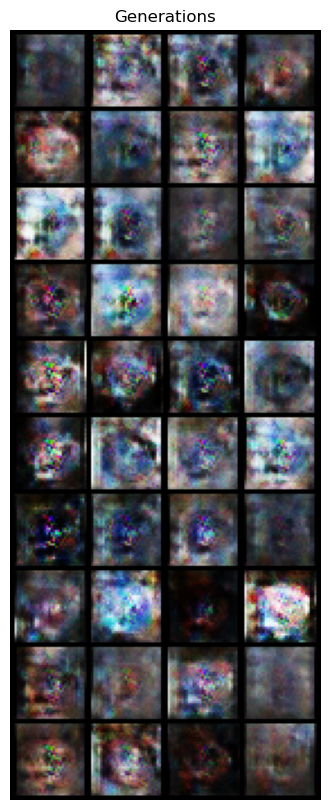

Epoch 31


100%|██████████| 138/138 [04:23<00:00,  1.91s/it]


Epoch 32


100%|██████████| 138/138 [04:32<00:00,  1.98s/it]


Discrimiantor loss: 17.0, Generator loss: 1.09e+02
Discrimiantor fake acc: 0.128, Discriminator real acc: 0.871
Epoch 33


100%|██████████| 138/138 [03:45<00:00,  1.63s/it]


Epoch 34


100%|██████████| 138/138 [04:11<00:00,  1.82s/it]


Discrimiantor loss: 17.5, Generator loss: 1.07e+02
Discrimiantor fake acc: 0.134, Discriminator real acc: 0.865
Epoch 35


100%|██████████| 138/138 [02:32<00:00,  1.11s/it]


Epoch 36


100%|██████████| 138/138 [01:15<00:00,  1.84it/s]


Discrimiantor loss: 16.7, Generator loss: 1.11e+02
Discrimiantor fake acc: 0.129, Discriminator real acc: 0.871
Epoch 37


100%|██████████| 138/138 [01:59<00:00,  1.15it/s]


Epoch 38


 51%|█████▏    | 71/138 [02:19<02:11,  1.96s/it]


KeyboardInterrupt: 

In [37]:
dcgan_model.fit(train_dataloader, loss_func, generator_optimizer, discriminator_optimizer, generator_lr_scheduler, discriminator_lr_scheduler, epochs=50)

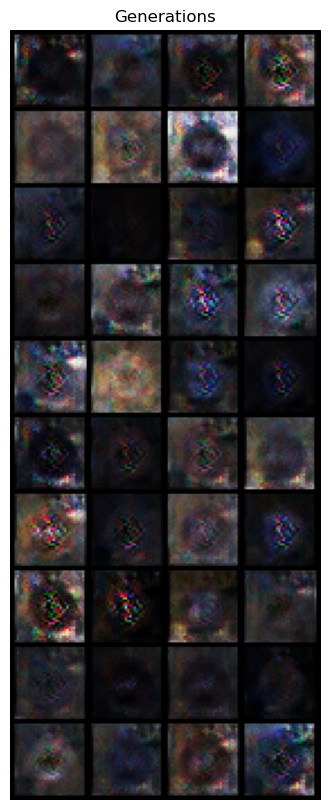

In [38]:
fixed_input_noise = torch.randn(min(40, BATCH_SIZE), dcgan_model.generator.latent_dim, 1, 1, device=device)

visualize_generated_images(dcgan_model.generate_images(fixed_input_noise))

## - VAEGAN

# Validation

In [175]:
# ConvVAE
conv_vae_model = ConvVAE(input_dim=input_shape[0], latent_dim=128, output_dim=32*32*3, device=device, tensorboard_dir='runs/models').to(device)
conv_vae_model.load_state_dict(torch.load('models/model_conv_vae_big_1.pt'))

# ConvVAE (Big)
conv_vae_model_big = ConvVAE(input_dim=input_shape[0], latent_dim=64, output_dim=32*32*3, device=device, tensorboard_dir='runs/models').to(device)
conv_vae_model_big.load_state_dict(torch.load('models/model_conv_vae_1.pt'))


# VAE (3)
vae_model_3 = VAE(input_dim=input_shape[0], # 3
            latent_dim=512,
            output_dim=input_shape[0], # 3
            device=device,
            tensorboard_dir='runs/vae_model'
            ).to(device)
vae_model_3.load_state_dict(torch.load('models/model_vae_sigmoid_3.pt'))


# VAE (4)
vae_model_4 = VAE(input_dim=input_shape[0], # 3
            latent_dim=512,
            output_dim=input_shape[0], # 3
            device=device,
            tensorboard_dir='runs/vae_model'
            ).to(device)
vae_model_4.load_state_dict(torch.load('models/model_vae_sigmoid_4.pt'))


# VanillaVAE (2)
vanilla_vae_model_2 = VanillaVAE(input_dim=32*32*3, latent_dim=128, output_dim=32*32*3, device=device, tensorboard_dir='runs/models').to(device)
vanilla_vae_model_2.load_state_dict(torch.load('models/model_vanilla_vae_2.pt'))

# VanillaVAE (4)
vanilla_vae_model_4 = VanillaVAE(input_dim=32*32*3, latent_dim=128, output_dim=32*32*3, device=device, tensorboard_dir='runs/models').to(device)
vanilla_vae_model_4.load_state_dict(torch.load('models/model_vanilla_vae_4.pt'))

# VanillaVAE (5)
vanilla_vae_model_5 = VanillaVAE(input_dim=32*32*3, latent_dim=128, output_dim=32*32*3, device=device, tensorboard_dir='runs/models').to(device)
vanilla_vae_model_5.load_state_dict(torch.load('models/model_vanilla_vae_5.pt'))


# VAE sigmoid (3)
vae_sigmoid_model_3 = VAE(input_dim=input_shape[0], # 3
                        latent_dim=512,
                        output_dim=input_shape[0], # 3
                        device=device,
                        tensorboard_dir='runs/vae_model'
                        ).to(device)
vae_sigmoid_model_3.load_state_dict(torch.load('models/model_vae_sigmoid_3.pt'))


# VAE sigmoid (4)
vae_sigmoid_model_4 = VAE(input_dim=input_shape[0], # 3
                        latent_dim=512,
                        output_dim=input_shape[0], # 3
                        device=device,
                        tensorboard_dir='runs/vae_model'
                        ).to(device)
vae_sigmoid_model_4.load_state_dict(torch.load('models/model_vae_sigmoid_4.pt'))


<All keys matched successfully>

In [193]:
class Evaluator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Evaluator, self).__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, 64)
        self.fc_out  = nn.Linear(64, num_classes)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def get_features(self, x):
        x = torch.flatten(x, 1)
        x = self.LeakyReLU(self.fc_1(x))
        x = self.LeakyReLU(self.fc_2(x))
        return x
    

    def forward(self, x):
        x = self.get_features(x)
        x = self.fc_out(x)
        return x

evaluator = Evaluator(32*32*3, 256).to(device)
evaluator

Evaluator(
  (fc_1): Linear(in_features=3072, out_features=256, bias=True)
  (fc_2): Linear(in_features=256, out_features=64, bias=True)
  (fc_out): Linear(in_features=64, out_features=43, bias=True)
  (LeakyReLU): LeakyReLU(negative_slope=0.2)
)

In [194]:
# Optimizers
optimizer = torch.optim.Adam(evaluator.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.97)

# loss
criterion = nn.CrossEntropyLoss()

In [195]:
num_epochs = 10
for epoch in tqdm(range(num_epochs)):
    for data, targets in iter(train_dataloader):
        data = data.to(device)
        targets = targets.to(device)

        results = evaluator(data)
        loss = criterion(results, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|██████████| 10/10 [00:52<00:00,  5.21s/it]


In [196]:
num_correct = 0
total_guesses = 0

evaluator.eval()
with torch.no_grad():
    for data, targets in iter(val_dataloader):
        # Sends data and targets to device
        data = data.to(device)
        targets = targets.to(device)

        # Acquires the network's best guesses at each class
        results = evaluator(data)
        best_guesses = torch.argmax(results, 1)

        # Updates number of correct and total guesses
        num_correct += torch.eq(targets, best_guesses).sum().item()
        total_guesses += len(targets)

print("Correctly guessed ", num_correct/total_guesses*100, "% of the dataset")

Correctly guessed  94.48979591836735 % of the dataset


### Using [Frechet Inception Distance metric](https://github.com/mseitzer/pytorch-fid):


In [197]:
orig_data = [x[0] for x in list(val_dataset)[:1000]]
orig_data = torch.stack(orig_data)

In [198]:
with torch.no_grad():
    fixed_noise_conv = torch.randn(1000, conv_vae_model.latent_dim, device=device)
    fixed_noise_conv_big = torch.randn(1000, conv_vae_model_big.latent_dim, device=device)
    fixed_noise_vae = torch.randn(1000, vae_model_3.latent_dim, device=device)
    fixed_labels = torch.randint(num_classes, (1000,), device=device)
    fixed_labels = F.one_hot(fixed_labels, num_classes).float()
    
    # Models
    generations_conv_vae_model = conv_vae_model.decoder(fixed_noise_conv)
    generations_conv_vae_model_big = conv_vae_model_big.decoder(fixed_noise_conv_big)
    generations_vae_model_3 = vae_model_3.decoder(fixed_noise_vae)
    generations_vae_model_4 = vae_model_4.decoder(fixed_noise_vae)
    
    generations_vanilla_vae_model_2 = vanilla_vae_model_2.decoder(torch.randn(1000, vanilla_vae_model_2.latent_dim, device=device))
    generations_vanilla_vae_model_4 = vanilla_vae_model_4.decoder(torch.randn(1000, vanilla_vae_model_4.latent_dim, device=device))
    generations_vanilla_vae_model_5 = vanilla_vae_model_5.decoder(torch.randn(1000, vanilla_vae_model_5.latent_dim, device=device))
    generations_vae_sigmoid_model_3 = vae_sigmoid_model_3.decoder(torch.randn(1000, vae_sigmoid_model_3.latent_dim, device=device))
    generations_vae_sigmoid_model_4 = vae_sigmoid_model_4.decoder(torch.randn(1000, vae_sigmoid_model_4.latent_dim, device=device))
    
    

In [199]:
with torch.no_grad():
    dist_orig_data = evaluator.get_features(orig_data.to(device)).cpu()
    dist_conv_vae_model = evaluator.get_features(generations_conv_vae_model.to(device)).cpu()
    dist_conv_vae_model_big = evaluator.get_features(generations_conv_vae_model_big.to(device)).cpu()
    dist_vae_model_3 = evaluator.get_features(generations_vae_model_4.to(device)).cpu()
    dist_vae_model_4 = evaluator.get_features(generations_vae_model_4.to(device)).cpu()
    
    dist_vanilla_vae_model_2 = evaluator.get_features(generations_vanilla_vae_model_2.to(device)).cpu()
    dist_vanilla_vae_model_4 = evaluator.get_features(generations_vanilla_vae_model_4.to(device)).cpu()
    dist_vanilla_vae_model_5 = evaluator.get_features(generations_vanilla_vae_model_5.to(device)).cpu()
    dist_vae_sigmoid_model_3 = evaluator.get_features(generations_vae_sigmoid_model_3.to(device)).cpu()
    dist_vae_sigmoid_model_4 = evaluator.get_features(generations_vae_sigmoid_model_4.to(device)).cpu()
    
    # dist_gan = evaluator.get_features(generations_gan.to(device)).cpu()

In [200]:
######### Frechet Inception distance based on implementation from https://github.com/mseitzer/pytorch-fid

import numpy as np
from scipy import linalg


def calculate_frechet_distance(distribution_1, distribution_2, eps=1e-6):
    mu1 = np.mean(distribution_1, axis=0)
    sigma1 = np.cov(distribution_1, rowvar=False)

    mu2 = np.mean(distribution_2, axis=0)
    sigma2 = np.cov(distribution_2, rowvar=False)

    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    Stable version by Dougal J. Sutherland.
    Params:
    -- mu1   : Numpy array containing the activations of a layer of the
               inception net (like returned by the function 'get_predictions')
               for generated samples.
    -- mu2   : The sample mean over activations, precalculated on an
               representative data set.
    -- sigma1: The covariance matrix over activations for generated samples.
    -- sigma2: The covariance matrix over activations, precalculated on an
               representative data set.
    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

In [201]:
orig_data_2 = [x[0] for x in list(val_dataset)[-1000:]]
orig_data_2 = torch.stack(orig_data_2)
with torch.no_grad():
    dist_orig_data_2 = evaluator.get_features(orig_data_2.to(device)).cpu()

In [202]:
model_names = [
    'orig', 
    'conv_vae_model', 
    'conv_vae_model_big',
    'vae_model_3',
    'vae_model_4',
    'vanilla_vae_model_2', 
    'vanilla_vae_model_4',
    'vanilla_vae_model_5',
    'vae_sigmoid_model_3',
    'vae_sigmoid_model_4'
    ]

models = [
    dist_orig_data_2.numpy(), 
    dist_conv_vae_model.numpy(), 
    dist_conv_vae_model_big.numpy(),
    dist_vae_model_3.numpy(),
    dist_vae_model_4.numpy(),
    dist_vanilla_vae_model_2.numpy(),
    dist_vanilla_vae_model_4.numpy(),
    dist_vanilla_vae_model_5.numpy(),
    dist_vae_sigmoid_model_3.numpy(),
    dist_vae_sigmoid_model_4.numpy()
    ]

In [203]:
for name, obj in zip(model_names, models):
    print(f"FD {name}: {calculate_frechet_distance(dist_orig_data.numpy(), obj)}")

FD orig: 34.74024430334248
FD conv_vae_model: 313.8658224236751
FD conv_vae_model_big: 370.2859322587401
FD vae_model_3: 672.5100737478924
FD vae_model_4: 672.5100737478924
FD vanilla_vae_model_2: 280.61922092118493
FD vanilla_vae_model_4: 288.9443072929198
FD vanilla_vae_model_5: 213.05343942103082
FD vae_sigmoid_model_3: 828.3235494266551
FD vae_sigmoid_model_4: 649.6654539866995


In [186]:
for name, obj in zip(model_names, models):
    print(f"FD {name}: {calculate_frechet_distance(dist_orig_data.numpy(), obj)}")

FD orig: 33.6880321818071
FD conv_vae_model: 298.4756393877569
FD conv_vae_model_big: 308.5219189254285
FD vae_model_3: 592.8177812434956
FD vae_model_4: 592.8177812434956
FD vanilla_vae_model_2: 251.66494647240052
FD vanilla_vae_model_4: 240.59966235625689
FD vanilla_vae_model_5: 200.23412724402078
FD vae_sigmoid_model_3: 747.2057010816229
FD vae_sigmoid_model_4: 583.0847325868112


## Generate samples

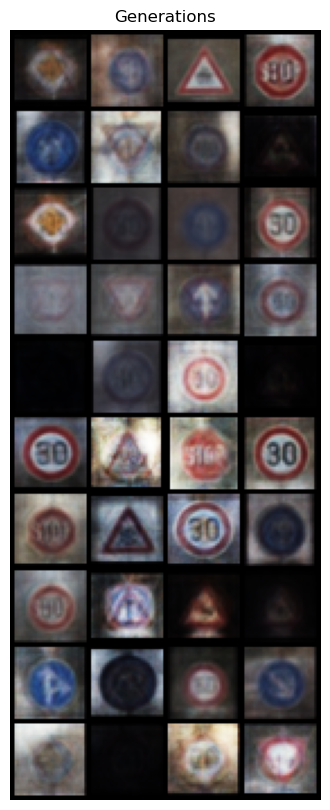

In [172]:
generated_images = conv_vae_model.generate_images(1000)

visualize_generated_images(generated_images[:40])

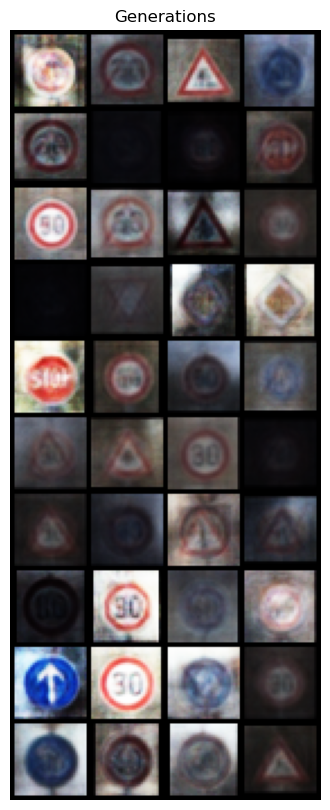

In [173]:
generated_images = vanilla_vae_model_4.generate_images(1000)

visualize_generated_images(generated_images[:40])

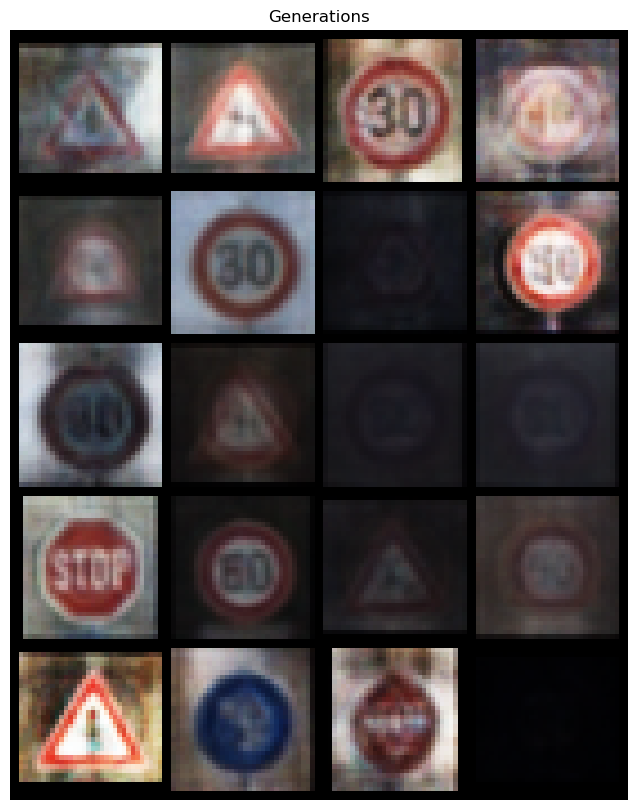

In [190]:
visualize_generated_images(generations_vanilla_vae_model_5[100:120])